### 웹 스크래핑 코드 정리

In [1]:
from selenium import webdriver
import chromedriver_autoinstaller # 자동설치
import time

import pandas as pd
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

In [2]:
# 크롬드라이브 버전 확인
chrome_ver = chromedriver_autoinstaller.get_chrome_version().split('.')[0]
chrome_ver

'115'

In [23]:
# 크롤러 정의

try:
    crawler = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe')
except:
    chromedriver_autoinstaller.insrall(True)
    crawler = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe')
crawler.implicitly_wait(10)
crawler.get('https://www.naver.com/')

C:\Users\koaro\AppData\Local\Temp\ipykernel_14288\3958494742.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  crawler = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe')


In [24]:
names = []
prices = []
review_cnts = []
links = []
cell_cnts = []

In [25]:
for i in range(1,3):
    crawler.get('https://search.shopping.naver.com/search/all?origQuery=%EB%8B%AD%EA%B0%80%EC%8A%B4%EC%82%B4&pagingIndex={0}&pagingSize=40&productSet=total&query=%EB%8B%AD%EA%B0%80%EC%8A%B4%EC%82%B4&sort=review&timestamp=&viewType=list'.format(i))
    
    while True: # 브라우저 크기 관련
        bh = crawler.execute_script("return document.body.scrollHeight") # 처음 브라우저 높이
        print(bh)
        time.sleep(5)
        crawler.execute_script("window.scrollTo(0, document.body.scrollHeight)") # 스크롤 내리기
        time.sleep(4)
        ah = crawler.execute_script("return document.body.scrollHeight") # 스크롤 다내렸을 때 브라우저 높이
        if ah == bh: # 처음 높이와 스크롤 내릴 때의 높이가 같아질 때 멈춰
            break
        bh = ah

    infos = crawler.find_elements(By.CSS_SELECTOR, ".product_info_area__xxCTi") # 클래스이름 앞에 .붙이기
    for info in infos: # infos에 있는 정보들을 가져올거임
        try:
            name = info.find_element(By.CSS_SELECTOR, ".product_title__Mmw2K").text # 텍스트만 필요
            names.append(name)
            price = info.find_element(By.CSS_SELECTOR, ".price_num__S2p_v").text # 텍스트만 필요
            prices.append(price)
            review_cnt = info.find_element(By.CSS_SELECTOR, ".product_num__fafe5").text # 텍스트만 필요
            review_cnts.append(review_cnt)
            
            try:
                cell_cnt = info.find_element(By.CSS_SELECTOR, ".product_num__fafe5").text # 텍스트만 필요
                cell_cnts.append(cell_cnt)
                
            except NoSuchElementException:
                cell_cnts.append('null')
                
            #link = info.find_element(By.CSS_SELECTOR, "a.product_link__TrAac.linkAnchor").get_attribute("href") # 클래스에 공백있으면 . 표시해주기
            #a.인 이유: a태그 안의 클래스가 product_link__TrAac linkAnchor인 요소에 대해 href를 가져오라는 의미
            #links.append(link)
            
        except:
            print('Exception')
            
crawler.close()

2024
9551
2002
9587


In [26]:
print(len(names))
print(len(prices))
print(len(review_cnts))
print(len(cell_cnts))

80
80
80
80


In [27]:
# 데이터프레임으로 저장
df = pd.DataFrame({'name':names, 'price':prices,'cell_cnt':cell_cnts})
df.head()

,name,price,cell_cnt
0,맛있닭 닭가슴살 59종 / 냉동 소세지 추천 수비드 훈제 스테이크 스팀,"1,790원","749,743"
1,잇메이트 닭가슴살 66종 / 훈제 스팀 저염 소세지 스테이크 헬스,"1,580원","575,771"
2,[아임닭] 닭가슴살/소시지/스테이크/주먹밥/볶음밥 外 96종 골라담기,"3,740원","379,374"
3,아임닭 닭가슴살 75종 / 훈제 스팀 저염 소세지 스테이크 헬스,990원,"370,636"
4,허닭 닭가슴살 스테이크/소시지/큐브 외 46종 골라담기,"1,050원","347,586"


### 형태소분류 정리

In [28]:
import re
from konlpy.tag import Okt
from konlpy.tag import Twitter # 고유 명사 인정해주는 라이브러리
from collections import Counter # jdk에서 제공
import pandas as pd

In [29]:
content_all = ''
for i in range(len(df['name'])):
    content_all = content_all + ' ' + df['name'].loc[i] # name 리스트 한줄로 잇기
    
content_all = re.sub('[^ㄱ-ㅣ가-힣]',"",content_all) # 이상한 문자 지우기
content_all = str(content_all)

In [30]:
okt = Okt()
nouns_txt = okt.nouns(content_all) # 명사 분류기 

In [ ]:
# 분류기에 없는 고유 문법을 임의로 인정시키는 방법
# 근데 지금은 필요X

Twitter = Twitter()
Twitter.add_dictionary('인정시키고 싶은 고유명사', 'Noun')

In [31]:
count = Counter(nouns_txt)  # 쪼개진 명사 개수 카운트
count = count.most_common() # 내림차순 정렬

In [32]:
rank_text = dict(count)
count_len = 2 # n번 이상 언급될 횟수 지정
temp_dic = {} 

for key, value in rank_text.items(): # .item 써야 키값, 밸류값 모두 반환
    if value > count_len:
        temp_dic[key] = value
    rank_text = temp_dic

stopword = pd.read_csv("C:/박규영/2023크롤링공부/불용어.csv")
stopword = list(stopword['불용어'])
stopword.append('어요') # 어요는 csv에 없었음

temp_dic = {}
for key, value in rank_text.items():
    if key not in stopword: 
        temp_dic[key] = value

In [33]:
if '닭닭' in temp_dic:
    temp_dic['닭'] = temp_dic.get('닭', 0) + temp_dic['닭닭']
    del temp_dic['닭닭']

In [ ]:
# 지우고 싶은 단어 지우기

temp_dic.pop(key) for key in ['지우고싶은 단어1','2']

### 크롤링한 단어 워드클라우드 정리

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

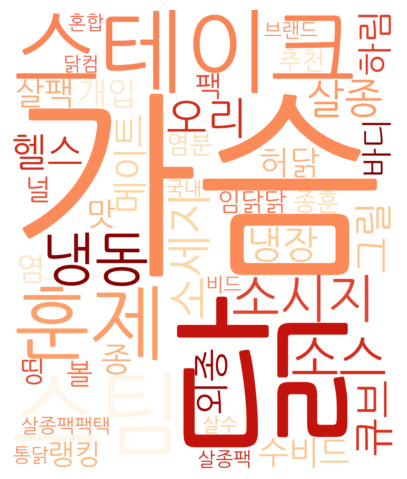

In [35]:
img_path = "C:/박규영/2023크롤링공부/chicken.png"

flower_mask = np.array(Image.open(img_path))

wordcloud = WordCloud(font_path = "C:/박규영/2023크롤링공부/NanumGothic.ttf",
                       colormap = 'OrRd',
                       background_color = 'white', mask = flower_mask)

wc = wordcloud.generate_from_frequencies(temp_dic)
plt.figure(figsize=(5,10))
plt.imshow(wc)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show();